# Ejemplo de identificación, estimación, diagnóstico y pronósticos de un modelo ARIMA

## Librerías


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [16]:
import statsmodels.api as sm
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from arch.unitroot import ADF

## Lectura de datos

Los datos corresponde al PIB de Colombia observado trimestralmente y desestacionalizado, desde el primer trimestre del año 2000 al cuarto trimestre del año 2015

In [3]:
z = pd.read_csv('../Data/PIB_real_2000_1_2015_4.txt', header=None, names=["x"])

In [4]:
len(z)

64

La serie es corta, esto puede dificultar la identiciación del proceso

In [5]:
# Agregamos columna de fechas
num_trimestres = len(z)

fechas_trimestrales = pd.date_range(start='2000-01-01', periods=num_trimestres, freq='QE')
z.index = fechas_trimestrales

print(z.head())
print()
print(z.tail())

                  x
2000-03-31  70991.0
2000-06-30  71017.0
2000-09-30  71421.0
2000-12-31  71332.0
2001-03-31  71846.0

                   x
2014-12-31  130168.0
2015-03-31  131171.0
2015-06-30  132204.0
2015-09-30  133601.0
2015-12-31  134400.0


## Etapa de Identificación

### **Análisis de estabilidad de varianza**

Es necesario usar la transformación de Box-Cox?

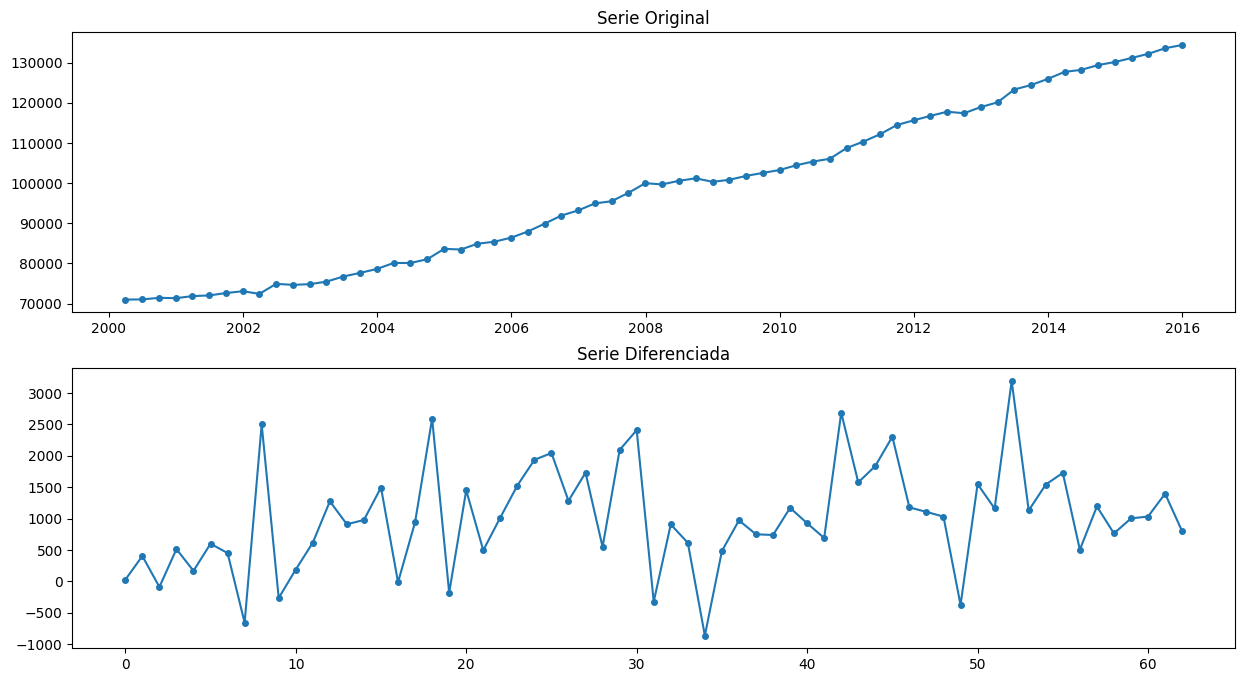

In [6]:

fig, axs = plt.subplots(2, figsize=(15,8))

axs[0].plot(z['x'], marker='o', markersize=4)
axs[0].set_title('Serie Original')

axs[1].plot(np.diff(z['x']), marker='o', markersize=4)
axs[1].set_title('Serie Diferenciada')

plt.show()

In [7]:
z_transformed, lambda_param = stats.boxcox(z['x'])
print("Parámetro lambda: ", lambda_param)

Parámetro lambda:  0.0050191921435269165


Box-Cox sugieren una transformación logarítmica, ya que el parámetro lambda se aproxima a cero. 



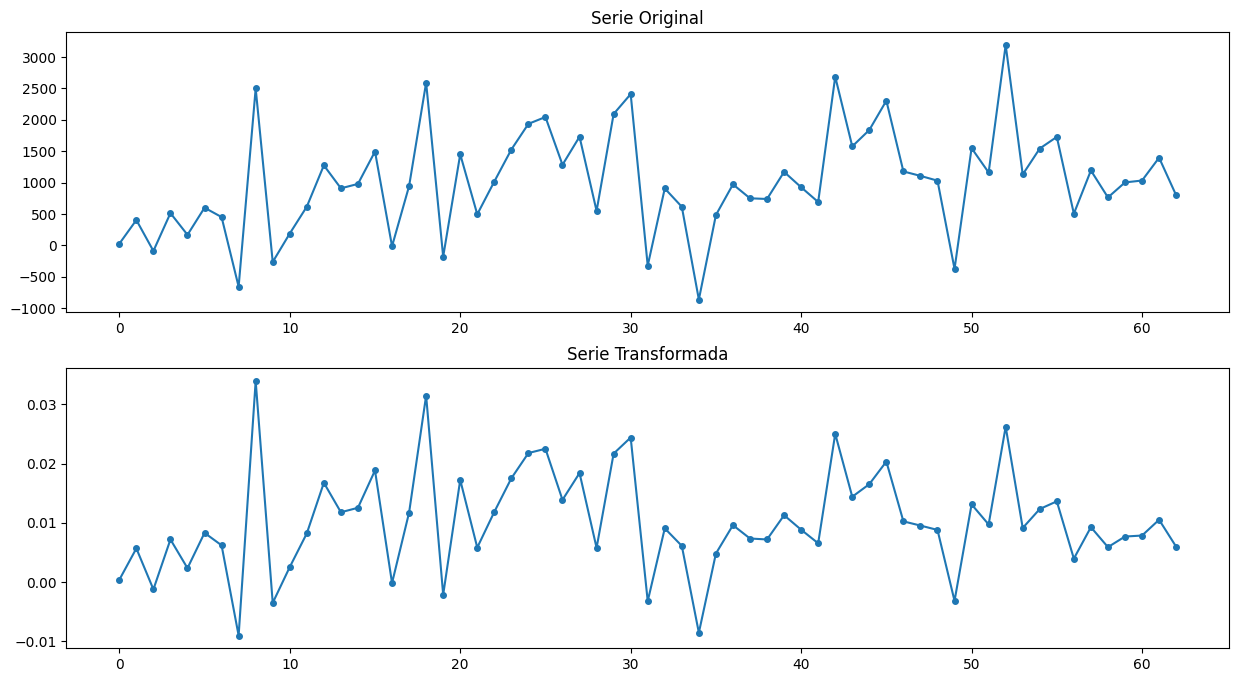

In [8]:
# Compraración de las primeras diferencias de la serie original y transformada:

fig, axs = plt.subplots(2, figsize=(15,8))

axs[0].plot(np.diff(z['x']), marker='o', markersize=4)
axs[0].set_title('Serie Original')

axs[1].plot(np.diff(np.log(z['x'])), marker='o', markersize=4)
axs[1].set_title('Serie Transformada')

plt.show()

Se observa que la transformación logarítmica no parece tener efecto.

**Conclusión:** se propone usar la transformación lambda=1, es decir, no transofrmar la serie y seguir trabajando con la serie original z

### Determinación del valor de d

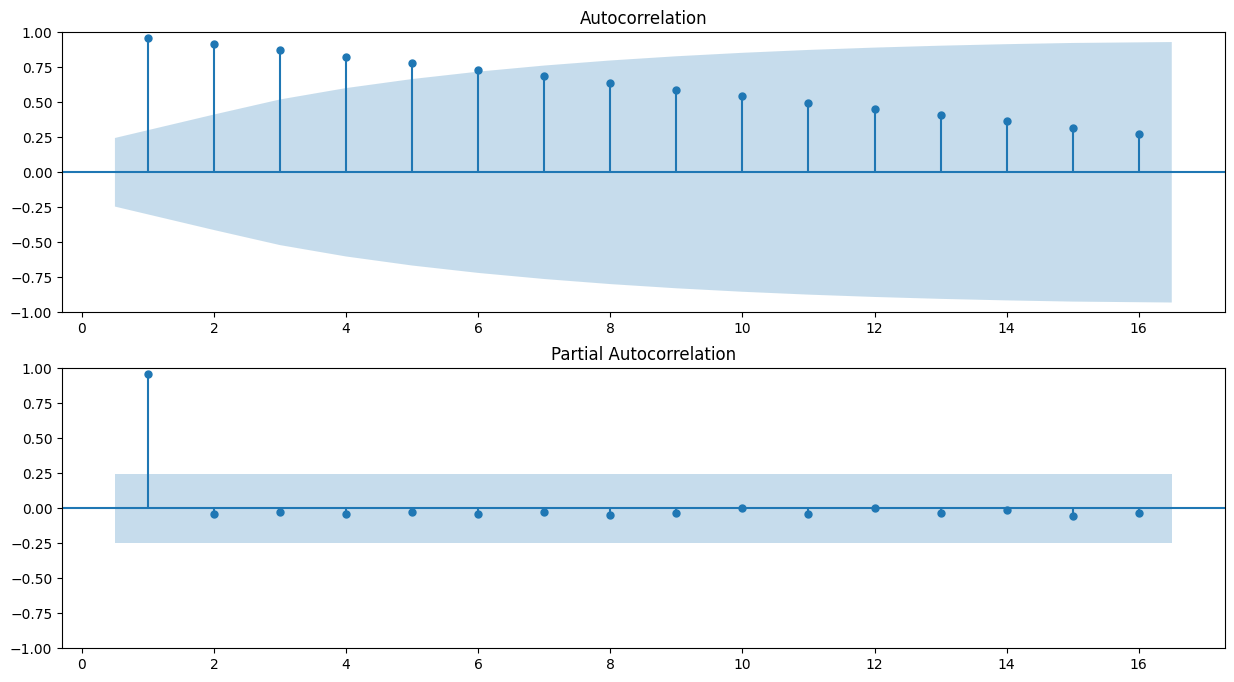

In [9]:
### Correlogramas muestrales de la serie original

# Cálcula el rezago máximo
max_rezag = round(len(z) / 4)

fig, axs = plt.subplots(2, figsize=(15,8))

# ACF
sm.graphics.tsa.plot_acf(z['x'], ax=axs[0], lags=max_rezag, alpha=0.05, zero=False)
# PACF
sm.graphics.tsa.plot_pacf(z['x'], ax=axs[1], lags=max_rezag, alpha=0.05, zero=False)

plt.show()

Del gráfico de z y sus correlogramas, se concluye que la serie es no estacionaria. Que tipo de serie es, TS o DS?

### Prueba de raíces unitarias


#### Usando [statsmodels](https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html)

In [10]:
maxlag = int(np.floor(12 * (len(z) / 100) ** (1/4)))
maxlag

10

In [13]:
# Usando el criterio AIC
ru_z = adfuller(z['x'], maxlag=maxlag, regression='ct', autolag='AIC', store=True, regresults=True)

In [14]:
print("Augmented Dickey-Fuller Test Unit Root Test")
print("ADF Statistics: ", ru_z[0])
print("p-value: ", ru_z[1])
print("Critical Values: ")
for key, value in ru_z[2].items():
    print(f"\t{key}: {value}")

Augmented Dickey-Fuller Test Unit Root Test
ADF Statistics:  -2.8173048814732637
p-value:  0.1906611693626084
Critical Values: 
	1%: -4.118172754629629
	5%: -3.486383398148148
	10%: -3.1713372222222223


Los resultados de la prueba de Dickey-Fuller Aumentada (ADF) se utilizan para determinar si una serie temporal es estacionaria. La prueba ADF tiene como hipótesis nula que una unidad de raíz está presente en una serie de tiempo (es decir, que la serie es no estacionaria).

* **ADF Statistic:** Es el valor del estadístico de la prueba ADF. Un valor más negativo indica una evidencia más fuerte contra la hipótesis nula.

* **p-value:** Es el valor p asociado con el estadístico de la prueba. Un valor p pequeño (generalmente menor a 0.05) rechaza la hipótesis nula, lo que indica que la serie es estacionaria.

* **Critical Values:** Son los valores críticos a diferentes niveles de significancia. Si el estadístico ADF es menor (más negativo) que el valor crítico, entonces se rechaza la hipótesis nula.

En este caso, el valor ADF es -2.81 y el valor p es 0.19. Como el valor p es mayor que 0.05, no se puede rechazar la hipótesis nula. Esto significa que hay evidencia fuerte para sugerir que la serie de tiempo no es estacionaria.

Además, el valor ADF es mayor que los valores críticos a los niveles de significancia del 1%, 5% y 10%. Esto refuerza la conclusión de que no se puede rechazar la hipótesis nula y por tanto, la serie se considera no estacionaria.

In [17]:
# Usando el criterio BIC
ru_z = adfuller(z['x'], maxlag=maxlag, regression='ct', autolag='BIC', store=True, regresults=True)
print("Augmented Dickey-Fuller Test Unit Root Test")
print("ADF Statistics: ", ru_z[0])
print("p-value: ", ru_z[1])
print("Critical Values: ")
for key, value in ru_z[2].items():
    print(f"\t{key}: {value}")

Augmented Dickey-Fuller Test Unit Root Test
ADF Statistics:  -2.937391250503978
p-value:  0.15043413343631373
Critical Values: 
	1%: -4.110169028582626
	5%: -3.482636994764984
	10%: -3.1691696870988255


#### Usando la librería [arch](https://arch.readthedocs.io/en/latest/unitroot/generated/arch.unitroot.ADF.html)